<a href="https://www.kaggle.com/code/emersonyu/house-prices-first-time-kaggle?scriptVersionId=102471587" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Inspired by [Soumi Ghosh](https://www.kaggle.com/code/soumighosh99/house-prices-89-score-with-xgboost/notebook), [Srishti Saha](https://www.kaggle.com/code/srishti280992/starter-code-eda-feature-engg-basic-model-v2/notebook?scriptVersionId=6419727), and [Niketan Moon](https://www.kaggle.com/code/niketanmoon/house-prices-prediction-part-2-with-fe/notebook).**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebraS
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_error

**Id is irrelevant until submission.**

In [3]:
train_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv').drop('Id',axis=1)
test_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
# for later use
test_ids = test_data.pop('Id')
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
test_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [6]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

**Some columns use nulls (NaNs) as categories, according to data_description.txt. Let's replace those with 'NA'.**

In [7]:
na_not_missing_cols = []
with open('../input/house-prices-advanced-regression-techniques/data_description.txt') as file:
    curr_label = None
    for line in file:
        if ':' in line:
            curr_label = line.split(':')[0]
        elif 'NA' in line:
            na_not_missing_cols.append(curr_label)
train_data[na_not_missing_cols].info()
for col in na_not_missing_cols:
    train_data[col].fillna('NA',inplace=True)
    test_data[col].fillna('NA',inplace=True)
print('Above cols in train/test contain nulls after processing: ' + str((train_data[na_not_missing_cols].isnull().any().any())) or (test_data[na_not_missing_cols].isnull().any().any()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Alley         91 non-null     object
 1   BsmtQual      1423 non-null   object
 2   BsmtCond      1423 non-null   object
 3   BsmtExposure  1422 non-null   object
 4   BsmtFinType1  1423 non-null   object
 5   BsmtFinType2  1422 non-null   object
 6   FireplaceQu   770 non-null    object
 7   GarageType    1379 non-null   object
 8   GarageFinish  1379 non-null   object
 9   GarageQual    1379 non-null   object
 10  GarageCond    1379 non-null   object
 11  PoolQC        7 non-null      object
 12  Fence         281 non-null    object
 13  MiscFeature   54 non-null     object
dtypes: object(14)
memory usage: 159.8+ KB
Above cols in train/test contain nulls after processing: False


**Now let's impute for the remaining nulls. We will first add binary columns (new features) to mark nulls in existing labels in train_data (and then do the same for those labels in test_data; note that we cannot add features based on test_data), and then we will use mean for numericals and mode for categoricals. Note that MSSubClass is actually categorical, but it has no nulls (as seen above), and it's already essentially self-ordinal-encoded, so we can just exclude it from this step (putting it through an imputer along with other categorical features could turn it into object dtype, which is unnecessary since it's encoded by default). Likewise, we don't have to worry about nulls in the target variable (if we had nulls in the target, we would probably remove those rows).**

In [8]:
# mark nulls
na_cols = [col for col in train_data.columns if train_data[col].isnull().any()]

nums = list(train_data.select_dtypes(exclude='object').columns)
cats = list(train_data.select_dtypes(exclude=np.number).columns)
nums.remove('SalePrice') # target
nums.remove('MSSubClass') # categorical

imputer = SimpleImputer() # default mean
train_data[nums] = pd.DataFrame(imputer.fit_transform(train_data[nums]),columns=nums)
test_data[nums] = pd.DataFrame(imputer.transform(test_data[nums]),columns=nums) # reuse mean from training
imputer = SimpleImputer(strategy='most_frequent')
train_data[cats] = pd.DataFrame(imputer.fit_transform(train_data[cats]),columns=cats)
test_data[cats] = pd.DataFrame(imputer.transform(test_data[cats]),columns=cats) # reuse mode from training
for col in na_cols: # mark nulls (binary-encoded categorical features)
    train_data['na_'+col] = train_data[col].isnull().astype('int64')
    test_data['na_'+col] = test_data[col].isnull().astype('int64')
print('Any nulls in train/test after processing: ' + str((train_data.isnull().any().any())) or (test_data.isnull().any().any()))

Any nulls in train/test after processing: False


**Next comes encoding the categorical variables. We will apply ordinal encoding to some features and dummy/one-hot encoding to others. Note that we don't care about multicollinearity since decision trees are immune to it.**

In [9]:
search = ['Street',
          'LotShape',
          'Utilities',
          'LandSlope',
          'BsmtFinType1',
          'BsmtFinType2',
          'BsmtExposure',
          'CentralAir',
          'Functional'
          'PavedDrive'] # looked at data_description.txt to determine which were obviously ordinal
ordinal_cols = []
all_categories = []
with open('../input/house-prices-advanced-regression-techniques/data_description.txt') as file:
    searching = False
    curr_label = None
    curr_categories = []
    for line in file:
        line = line.strip('\n').strip()
        if line == '':
            if curr_categories: # empty string and non-empty list indicates end of categories
                ordinal_cols.append(curr_label)
                all_categories.append(curr_categories)
                searching = False
                curr_label = None
                curr_categories = []
        elif ':' in line: # checking for ordinal categorical variables
            curr_label = line.split(':')[0]
            if 'Overall' in curr_label:
                pass
            elif 'Q' in curr_label:
                searching = True
            elif curr_label[-4:] == 'Cond':
                searching = True
            else:
                for string in search:
                    if string in curr_label:
                        search.remove(string)
                        searching = True
            if not searching:
                curr_label = None
        elif searching: # not an empty string but searching means currently on a category
            split = line.split()
            if len(split)>1:
                curr_categories.append(split[0])
                
for i,label in enumerate(ordinal_cols):
    print(label + '-'*(15-len(label)) + str(all_categories[i]))
    cats.remove(label)
    
encoder = OrdinalEncoder(categories=all_categories) # thankfully no errors caused by unknown values (typos)
                
train_data[ordinal_cols] = encoder.fit_transform(train_data[ordinal_cols])
test_data[ordinal_cols] = encoder.transform(test_data[ordinal_cols])

train_data[ordinal_cols].head()

Street---------['Grvl', 'Pave']
LotShape-------['Reg', 'IR1', 'IR2', 'IR3']
Utilities------['AllPub', 'NoSewr', 'NoSeWa', 'ELO']
LandSlope------['Gtl', 'Mod', 'Sev']
ExterQual------['Ex', 'Gd', 'TA', 'Fa', 'Po']
ExterCond------['Ex', 'Gd', 'TA', 'Fa', 'Po']
BsmtQual-------['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
BsmtCond-------['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
BsmtExposure---['Gd', 'Av', 'Mn', 'No', 'NA']
BsmtFinType1---['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
BsmtFinType2---['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
HeatingQC------['Ex', 'Gd', 'TA', 'Fa', 'Po']
CentralAir-----['N', 'Y']
KitchenQual----['Ex', 'Gd', 'TA', 'Fa', 'Po']
FireplaceQu----['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
GarageQual-----['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
GarageCond-----['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
PoolQC---------['Ex', 'Gd', 'TA', 'Fa', 'NA']


,Street,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,3.0,0.0,5.0,0.0,1.0,1.0,5.0,2.0,2.0,4.0
1,1.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,0.0,1.0,5.0,0.0,1.0,2.0,2.0,2.0,2.0,4.0
2,1.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,0.0,5.0,0.0,1.0,1.0,2.0,2.0,2.0,4.0
3,1.0,1.0,0.0,0.0,2.0,2.0,2.0,1.0,3.0,1.0,5.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0
4,1.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,0.0,5.0,0.0,1.0,1.0,2.0,2.0,2.0,4.0


MSZoning          5
Alley             3
LandContour       4
LotConfig         5
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
Foundation        6
Heating           6
Electrical        5
Functional        7
GarageType        7
GarageFinish      4
PavedDrive        3
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64


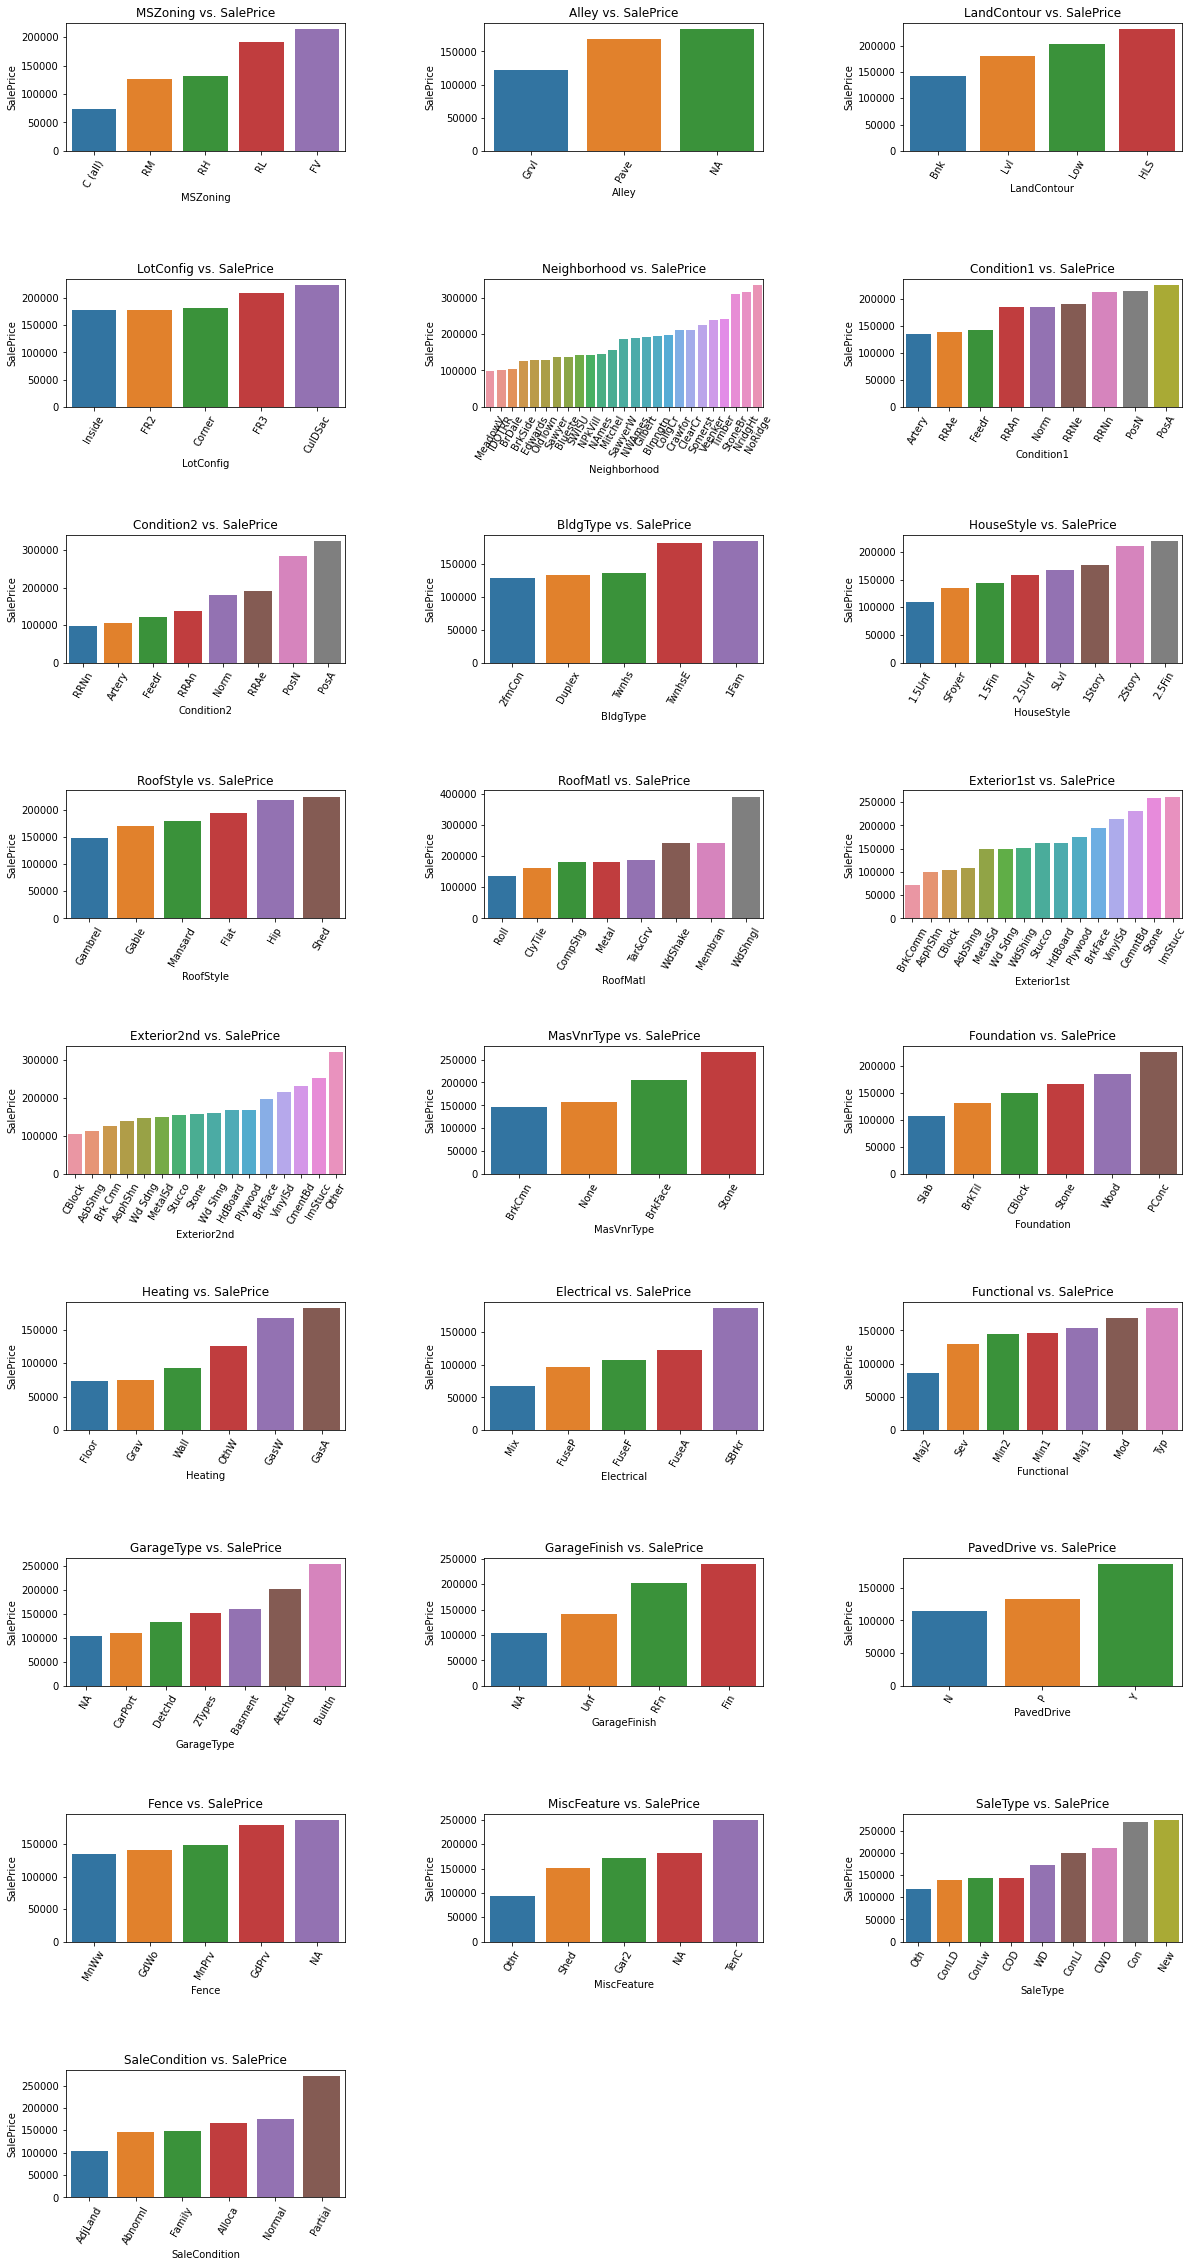

In [10]:
print(train_data[cats].nunique()) # none of them need target encoding
# graphing to see if there is anything worth dropping
def bar_plot(col):
    grouped = train_data.SalePrice.groupby(train_data[col]).mean().reset_index()
    sns.barplot(x=grouped[col],y=grouped.SalePrice,order=grouped.sort_values('SalePrice')[col])
    plt.title(col+' vs. SalePrice')
    plt.xticks(rotation=60)

plt.figure(figsize=(20,40))
plt.subplots_adjust(wspace=0.5,hspace=1)
i=1
for col in cats:
    plt.subplot(9,3,i)
    bar_plot(col)
    i+=1
plt.show()

**I see something weird! 'C (all)' is used instead of 'C', and upon further investigation, I found even more inconsistencies with the dataset's documentation (data_description.txt), including typos. Let's fix that.**

In [11]:
labels = train_data.columns
all_categories = []
with open('../input/house-prices-advanced-regression-techniques/data_description.txt') as file:
    searching = False
    curr_label = None
    curr_categories = []
    for line in file:
        line = line.strip('\n').strip()
        if line == '':
            if curr_categories: # empty string and non-empty list indicates end of categories
                all_categories.append(curr_categories)
                searching = False
                curr_label = None
                curr_categories = []
        elif ':' in line and not searching: # checking for categorical variables
            curr_label = line.split(':')[0]
            if curr_label in cats:
                searching = True
            if not searching:
                curr_label = None
        elif searching: # not an empty string but searching means currently on a category
            split = line.split()
            if len(split)>1:
                curr_categories.append(split[0].lower())
# last variable has no new line afterward
all_categories.append(curr_categories)
# change wd to wd sdng
all_categories[cats.index('Exterior1st')][all_categories[cats.index('Exterior1st')].index('wd')] = 'wd sdng'
all_categories[cats.index('Exterior2nd')][all_categories[cats.index('Exterior2nd')].index('wd')] = 'wd sdng'
# handling typos
train_data[cats] = train_data[cats].applymap(lambda x:x.lower())
test_data[cats] = test_data[cats].applymap(lambda x:x.lower())

def fix_typo1(value):
    if value == 'brk cmn':
        return 'brkcomm'
    elif value == 'cmentbd':
        return 'cemntbd'
    elif value == 'wd shng':
        return 'wdshing'
    return value

def fix_typo2(value):
    if value == 'duplex':
        return 'duplx'
    elif value == 'twnhs':
        return 'twnhsi'
    return value

def fix_typo3(value):
    if value == 'c (all)':
        return 'c'
    return value

train_data.Exterior2nd = train_data.Exterior2nd.apply(fix_typo1)
test_data.Exterior2nd = test_data.Exterior2nd.apply(fix_typo1)
train_data.BldgType = train_data.BldgType.apply(fix_typo2)
test_data.BldgType = test_data.BldgType.apply(fix_typo2)
train_data.MSZoning = train_data.MSZoning.apply(fix_typo3)
test_data.MSZoning = test_data.MSZoning.apply(fix_typo3)

# code used to check for typos

typos = {}
for i,cat in enumerate(cats):
    for j,value in train_data[cat].items():
        if value not in all_categories[i]:
            if typos.get(value) is None:
                typos[value] = 1
            else:
                typos[value] += 1
            print(cat + " : " + str(j) + ' : ' + value + ' : ' + str(all_categories[i]))
if typos:
    print(typos)
else:
    print('No more typos in train_data.')
            
typos = {}
for i,cat in enumerate(cats):
    for j,value in test_data[cat].items():
        if value not in all_categories[i]:
            if typos.get(value) is None:
                typos[value] = 1
            else:
                typos[value] += 1
            print(cat + " : " + str(j) + ' : ' + value + ' : ' + str(all_categories[i]))
if typos:
    print(typos)
else:
    print('No more typos in test_data.')

# wd sdng has space in it (Exterior1st & Exterior2nd)
# duplex -> duplx (BldgType)
# twnhs -> twnhsi (BldgType)
# cmentbd -> cemntbd (Exterior2nd)
# wd shng -> wdshing (Exterior2nd)
# brk cmn -> brkcomm (Exterior2nd)

# correct = {}
# for i,cat in enumerate(cats):
#     for j,value in train_data[cat].items():
#         if value in all_categories[i]:
#             if correct.get(value) is None:
#                 correct[value] = 1
#             else:
#                 correct[value] += 1
# # print(correct['duplx']) # error, see below
# print(correct['twnhse'])
# # print(correct['twnhsi']) # error, see below
# print(correct['cemntbd'])
# print(correct['wdshing'])
# print(correct['brkcomm'])
# print(correct['brkcmn'])

# correct = {}
# for i,cat in enumerate(cats):
#     for j,value in test_data[cat].items():
#         if value in all_categories[i]:
#             if correct.get(value) is None:
#                 correct[value] = 1
#             else:
#                 correct[value] += 1
# # print(correct['duplx'])
# print(correct['twnhse'])
# # print(correct['twnhsi']) # duplex is used instead of duplx, and twnhs is used instead of twnhsi
# print(correct['cemntbd'])
# print(correct['wdshing'])
# print(correct['brkcomm'])
# print(correct['brkcmn'])

No more typos in train_data.
No more typos in test_data.


In [12]:
for i,label in enumerate(cats):
    print(label + '-'*(15-len(label)) + str(all_categories[i]))

onehot = OneHotEncoder(categories=all_categories,sparse=False) # categories not in training set are ignored, return NumPy array
oh_train = pd.DataFrame(onehot.fit_transform(train_data[cats])) # FutureWarning isn't our problem
oh_test = pd.DataFrame(onehot.transform(test_data[cats]))
oh_train.columns = onehot.get_feature_names_out()
oh_test.columns = onehot.get_feature_names_out() # add back column labels
train_data = pd.concat([train_data.drop(columns=cats),oh_train],axis=1)
test_data = pd.concat([test_data.drop(columns=cats),oh_test],axis=1)

print('train_data and test_data have same columns (except SalePrice): ' + str(sum(train_data.drop(columns='SalePrice').columns==test_data.columns)==len(train_data.drop(columns='SalePrice').columns)==len(test_data.columns)))

MSZoning-------['a', 'c', 'fv', 'i', 'rh', 'rl', 'rp', 'rm']
Alley----------['grvl', 'pave', 'na']
LandContour----['lvl', 'bnk', 'hls', 'low']
LotConfig------['inside', 'corner', 'culdsac', 'fr2', 'fr3']
Neighborhood---['blmngtn', 'blueste', 'brdale', 'brkside', 'clearcr', 'collgcr', 'crawfor', 'edwards', 'gilbert', 'idotrr', 'meadowv', 'mitchel', 'names', 'noridge', 'npkvill', 'nridght', 'nwames', 'oldtown', 'swisu', 'sawyer', 'sawyerw', 'somerst', 'stonebr', 'timber', 'veenker']
Condition1-----['artery', 'feedr', 'norm', 'rrnn', 'rran', 'posn', 'posa', 'rrne', 'rrae']
Condition2-----['artery', 'feedr', 'norm', 'rrnn', 'rran', 'posn', 'posa', 'rrne', 'rrae']
BldgType-------['1fam', '2fmcon', 'duplx', 'twnhse', 'twnhsi']
HouseStyle-----['1story', '1.5fin', '1.5unf', '2story', '2.5fin', '2.5unf', 'sfoyer', 'slvl']
RoofStyle------['flat', 'gable', 'gambrel', 'hip', 'mansard', 'shed']
RoofMatl-------['clytile', 'compshg', 'membran', 'metal', 'roll', 'tar&grv', 'wdshake', 'wdshngl']
Exteri

**Now we need to process our numerical variables, including the target. Note that feature scaling is redundant with decision trees, and decision trees are robust to outliers in the features, but transforming the target and dealing with its outliers can help.**

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

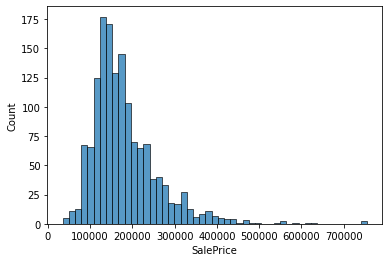

In [13]:
sns.histplot(train_data.SalePrice)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

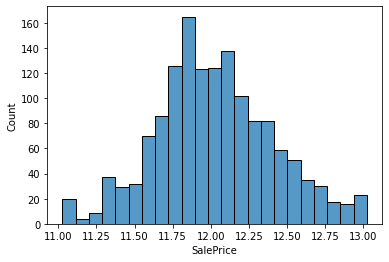

In [14]:
def cap_outliers(col):
    q1 = col.describe()[4]
    q3 = col.describe()[6]
    margin = 1.5*(q3-q1)
    upper = q3 + margin
    lower = q1 - margin
    col.mask(col>upper,upper,inplace=True)
    col.mask(col<lower,lower,inplace=True)

train_data.SalePrice = np.log(train_data.SalePrice)
cap_outliers(train_data.SalePrice)
sns.histplot(train_data.SalePrice)

**Let's use permutation importance to help us select features.**

In [15]:
y = train_data.SalePrice
X = train_data.drop(columns='SalePrice')
xgb_model = XGBRegressor(n_estimators=950,learning_rate=0.05,n_jobs=-1)
print(f'cross_val_score = {np.mean(cross_val_score(xgb_model,X,y,n_jobs=-1))}')

cross_val_score = 0.9065305691537894


In [16]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,random_state=0,test_size=0.2)
xgb_model.fit(X_train,y_train,verbose=False)
perm = PermutationImportance(xgb_model,random_state=0,n_iter=10).fit(X_valid,y_valid) # n_iter makes this slow but precise
importances = eli5.explain_weights_df(perm,feature_names=list(X.columns)).sort_values(by='weight',ascending=False)
importances.index = importances.feature
importances.drop(columns='feature',inplace=True)
print(importances.to_string())

                             weight           std
feature                                          
GrLivArea              1.617828e-01  1.319819e-02
OverallQual            1.051736e-01  8.463840e-03
TotalBsmtSF            3.783254e-02  6.019247e-03
LotArea                1.977463e-02  3.715571e-03
OverallCond            1.314262e-02  2.031644e-03
BsmtFinSF1             1.146731e-02  2.158840e-03
GarageCars             1.136967e-02  2.151804e-03
YearBuilt              9.621279e-03  2.660468e-03
YearRemodAdd           9.135663e-03  2.930068e-03
KitchenQual            7.011761e-03  1.828953e-03
LotFrontage            5.707582e-03  2.588005e-03
BsmtQual               4.154447e-03  1.080203e-03
1stFlrSF               3.958620e-03  1.578405e-03
FireplaceQu            2.783299e-03  1.721306e-03
BsmtFinType1           2.540620e-03  1.009352e-03
SaleCondition_family   2.178292e-03  2.582413e-04
Condition1_artery      2.168890e-03  8.512809e-04
Neighborhood_crawfor   2.037576e-03  1.043499e-03


In [17]:
# for i in np.arange(3,9): # choosing a cutoff
#     print(f'cutoff = {i}')
#     chosen = list(importances[importances.weight>=1/(10**i)].index)
#     print(f'{len(chosen)} features selected out of {len(importances.index)}')
#     X = train_data[list(chosen)]
#     xgb_model = XGBRegressor(n_estimators=950,learning_rate=0.05,n_jobs=-1)
#     print(f'cross_val_score = {np.mean(cross_val_score(xgb_model,X,y,n_jobs=-1))}')
#     print()

chosen = list(importances[importances.weight>=0.000001].index)
for feature in chosen:
    print(feature)
print(f'{len(chosen)} features selected out of {len(importances.index)}')
train_data = train_data[['SalePrice']+list(chosen)]
test_data = test_data[chosen]
X = train_data.drop(columns='SalePrice')
xgb_model = XGBRegressor(n_estimators=950,learning_rate=0.05,n_jobs=-1)
print(f'cross_val_score = {np.mean(cross_val_score(xgb_model,X,y,n_jobs=-1))}')

GrLivArea
OverallQual
TotalBsmtSF
LotArea
OverallCond
BsmtFinSF1
GarageCars
YearBuilt
YearRemodAdd
KitchenQual
LotFrontage
BsmtQual
1stFlrSF
FireplaceQu
BsmtFinType1
SaleCondition_family
Condition1_artery
Neighborhood_crawfor
WoodDeckSF
GarageYrBlt
SaleCondition_abnorml
GarageArea
BsmtExposure
MoSold
Functional_typ
ScreenPorch
Exterior1st_brkface
BsmtFinSF2
MSZoning_rm
Functional_maj2
2ndFlrSF
PoolArea
SaleCondition_normal
LotConfig_culdsac
ExterCond
BedroomAbvGr
HeatingQC
Neighborhood_sawyer
Neighborhood_brkside
MasVnrArea
HouseStyle_slvl
Neighborhood_oldtown
MSSubClass
MSZoning_rl
LandContour_bnk
TotRmsAbvGrd
Neighborhood_names
HouseStyle_1.5fin
GarageType_attchd
ExterQual
Exterior1st_brkcomm
Exterior1st_asbshng
LotShape
KitchenAbvGr
BsmtCond
BsmtUnfSF
OpenPorchSF
LandContour_lvl
Fireplaces
Foundation_brktil
Exterior1st_hdboard
Exterior2nd_plywood
Neighborhood_stonebr
Neighborhood_somerst
Neighborhood_nwames
Neighborhood_mitchel
LotConfig_fr2
LowQualFinSF
GarageFinish_rfn
RoofMatl_co

**Time for feature engineering! Decision trees aren't great at learning counts (they cannot easily sum information from many features at once).**

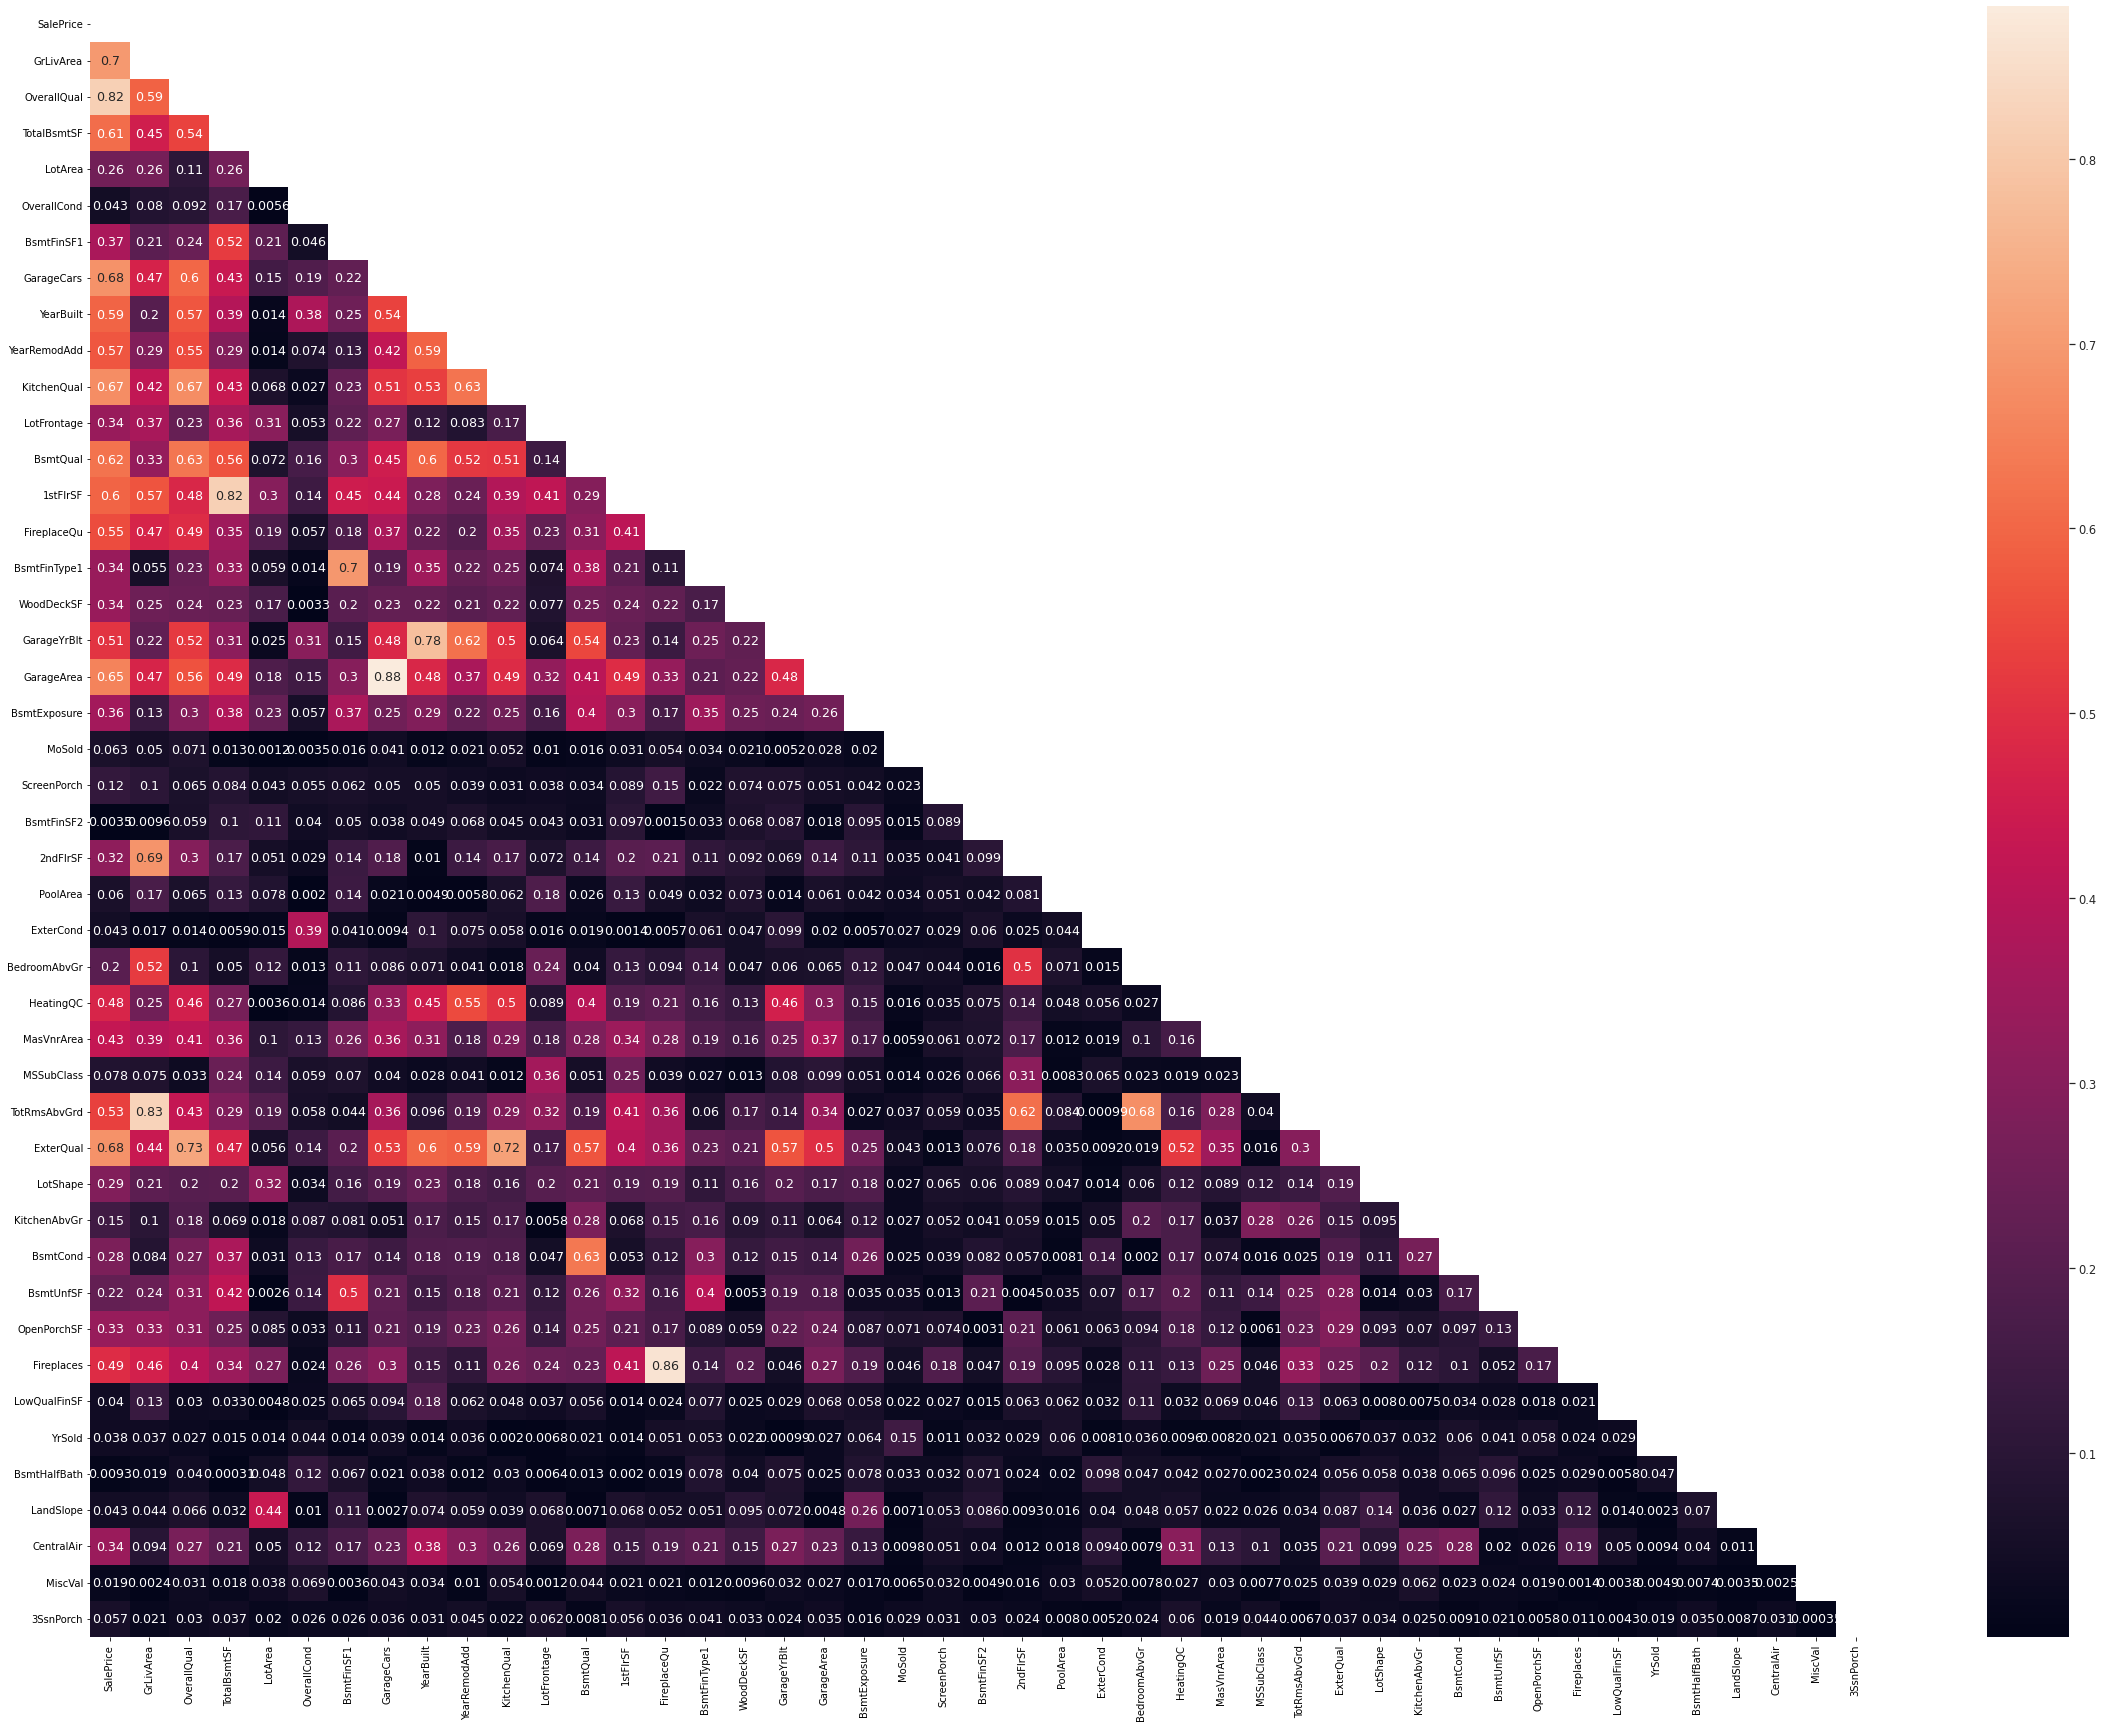

In [18]:
non_dummy_cols = [col for col in list(train_data.columns) if '_' not in col]
corr_mat = abs(train_data[non_dummy_cols].corr())
fig,ax = plt.subplots(figsize=(40,30))
sns.set(font_scale=1.05)
sns.heatmap(corr_mat,annot=True,mask=np.triu(corr_mat))
plt.show()

In [19]:
to_add = ['GrLivArea','TotalBsmtSF','LotArea','GarageArea','WoodDeckSF','ScreenPorch','PoolArea','MasVnrArea','OpenPorchSF','3SsnPorch']
# none: 0.918705749881274
# all: 0.9187827357696641
# testing removal of one:
# - GrLivArea: 0.9188670726085466
# - TotalBsmtSF: 0.9187886314666489
# - LotArea: 0.9197009218268437
# - LotFrontage: 0.9204940516208472 <<<
# - GarageArea: 0.919545455542074
# - WoodDeckSF: 0.9191879655838413
# - ScreenPorch: 0.9189140539707881
# - PoolArea: 0.9184020036506262
# - MasVnrArea: 0.9178427231901451
# - OpenPorchSF: 0.9183481807614333
# - 3SsnPorch: 0.9184157248284194
train_data['SumArea'] = train_data.loc[:,to_add].sum(axis=1)
test_data['SumArea'] = test_data.loc[:,to_add].sum(axis=1)
X = train_data.drop(columns='SalePrice')

**Almost done! Next comes tuning hyperparameters (commented out because it takes several hours).**

In [20]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,random_state=0,test_size=0.2)

# params = {'max_depth':np.arange(3,10,2),
#           'min_child_weight':np.arange(1,6,2),
#           'gamma':[i/10 for i in np.arange(0,4)],
#           'subsample':[i/10 for i in np.arange(7,10)],
#           'alpha':[0,0.001,0.005,0.01,0.05]}
# grid = GridSearchCV(xgb_model,param_grid=params,scoring='r2',return_train_score=True,verbose=2,n_jobs=-1)
# grid.fit(X_train,y_train)
# print(f'best_params_ = {grid.best_params_}')

# best_params_ = best_params_ = {'alpha': 0, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9}

**Let's take a deeper look.**

In [21]:
# xgb_model = XGBRegressor(n_estimators=950,learning_rate=0.05,n_jobs=-1,max_depth=3,min_child_weight=3,subsample=0.9)
# print(f'cross_val_score (for subsample=0.9) = {np.mean(cross_val_score(xgb_model,X,y,n_jobs=-1))}')

xgb_model = XGBRegressor(n_estimators=950,learning_rate=0.05,n_jobs=-1,max_depth=3,min_child_weight=3)
print(f'cross_val_score (for default subsample=1) = {np.mean(cross_val_score(xgb_model,X,y,n_jobs=-1))}')

# default subsample is better



# xgb_model = XGBRegressor(n_estimators=950,learning_rate=0.05,n_jobs=-1,max_depth=2,min_child_weight=3)
# print(f'cross_val_score (for max_depth=2) = {np.mean(cross_val_score(xgb_model,X,y,n_jobs=-1))}')

# xgb_model = XGBRegressor(n_estimators=950,learning_rate=0.05,n_jobs=-1,max_depth=4,min_child_weight=3)
# print(f'cross_val_score (for max_depth=4) = {np.mean(cross_val_score(xgb_model,X,y,n_jobs=-1))}')

# max_depth=3 is still best



xgb_model = XGBRegressor(n_estimators=950,learning_rate=0.05,n_jobs=-1,max_depth=3,min_child_weight=2)
print(f'cross_val_score (for min_child_weight=2) = {np.mean(cross_val_score(xgb_model,X,y,n_jobs=-1))}')

# min_child_weight=2 is better

cross_val_score (for default subsample=1) = 0.9180947082152304
cross_val_score (for min_child_weight=2) = 0.9204940516208472


**Let's submit! Note that I have to use exp to undo the log transformation of the predictions.**

In [22]:
xgb_model.fit(X_train,y_train,verbose=False)
print(f'RMSLE = {mean_squared_error(np.log1p(np.exp(y_valid)),np.log1p(np.exp(xgb_model.predict(X_valid))),squared=False)}') # evaluate on validation set using same metric used in Kaggle competition, for comparison
pd.DataFrame({'Id':test_ids,'SalePrice':np.exp(xgb_model.predict(test_data))}).to_csv('submission.csv',index=False)

RMSLE = 0.11283738191891536


**Possible improvements include:**
* **stacking**